# 3章 傾向スコアを用いた分析

## 3.2 傾向スコアを利用した効果の推定

### 3.2.1 マッチング

Z=1のユーザーに対して、傾向スコアが近い値のZ=0のユーザーをペアにする。この差を平均して処置効果を求める。  
Z=1に対してマッチングさせるので、推定される効果はATT。  
マッチング方法は閾値を設定したり、復元抽出するかどうかなど、パターンは様々である。

In [2]:
import pandas as pd

biased_df = pd.read_pickle('data/biased_df.pkl')

#### 傾向スコアを算出

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

y = biased_df['treatment']
X = pd.get_dummies(biased_df[['recency', 'channel', 'history']], columns=['channel'], drop_first=True)

lr = LogisticRegression(random_state=42)
lr.fit(X, y)
print(lr.score(X, y))
ps_score = lr.predict_proba(X)[:, 1]

0.6380579483163665


In [59]:
ps_score

array([0.51058501, 0.52522118, 0.91262317, ..., 0.34927944, 0.36110886,
       0.33838045])

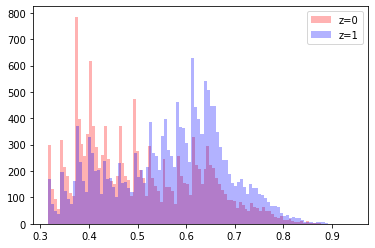

In [60]:
import matplotlib.pyplot as plt

plt.hist(ps_score[y[y == 0].index], label='z=0', color='red', alpha=0.3, histtype='stepfilled', bins=100)
plt.hist(ps_score[y[y == 1].index], label='z=1', color='blue', alpha=0.3, histtype='stepfilled', bins=100)
plt.legend()

理想はZ=0, 1で傾向スコアの分布が似ている方が良い。

0.6467434148805555

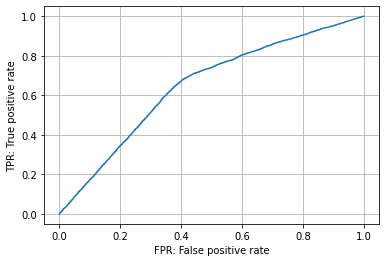

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y, ps_score, drop_intermediate=False)
plt.plot(fpr, tpr)
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

roc_auc_score(y, ps_score)

AUCが0.7以上のほうが良い、という基準もあるが、最近は共変量のバランスが取れているかが重要らしい

In [20]:
z_ps = pd.DataFrame({'treatment': y, 'ps_score': ps_score})
z_0 = z_ps[z_ps['treatment'] == 0]
z_1 = z_ps[z_ps['treatment'] == 1]

#### マッチング

In [21]:
from sklearn.neighbors import NearestNeighbors

# z=0のユーザーを数直線上に並べるイメージ
nn = NearestNeighbors(n_neighbors=1).fit(z_0['ps_score'].values.reshape(-1, 1))
# z=1の各ユーザーに対して、距離（スコア）が最も近いz=0のユーザーとの距離、インデックスを求めている。
distances, indices = nn.kneighbors(z_1['ps_score'].values.reshape(-1, 1))

In [22]:
match = pd.concat([
    z_1.reset_index()
    , z_0.reset_index().loc[indices.reshape(1, -1)[0]]
], axis=0, ignore_index=True)
match

,index,treatment,ps_score
0,6550,1,0.495245
1,6551,1,0.496468
2,6552,1,0.622064
3,6553,1,0.523390
4,6554,1,0.708428
...,...,...,...
34331,27694,0,0.316614
34332,22255,0,0.510151
34333,26215,0,0.349286
34334,26841,0,0.361114


In [23]:
match_df = match.merge(biased_df.reset_index()[['index', 'spend']], on='index', how='left')
match_df

,index,treatment,ps_score,spend
0,6550,1,0.495245,0.0
1,6551,1,0.496468,0.0
2,6552,1,0.622064,0.0
3,6553,1,0.523390,0.0
4,6554,1,0.708428,0.0
...,...,...,...,...
34331,27694,0,0.316614,0.0
34332,22255,0,0.510151,0.0
34333,26215,0,0.349286,0.0
34334,26841,0,0.361114,0.0


#### 効果の推定

In [25]:
import statsmodels.api as sm

x = sm.add_constant(match_df['treatment'])
results = sm.OLS(match_df['spend'], x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     28.91
Date:                Wed, 05 Aug 2020   Prob (F-statistic):           7.62e-08
Time:                        12:32:21   Log-Likelihood:            -1.4351e+05
No. Observations:               34336   AIC:                         2.870e+05
Df Residuals:                   34334   BIC:                         2.870e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6241      0.121      5.172      0.000       0.388       0.861
treatment      0.9176      0.171      5.377      0.000       0.583       1.252
==============================================================================
Omnibus:                    76831.896   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        408492152.212
Skew:                          21.273   Prob(JB):                         0.00
Kurtosis:                     535.650   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

本ではtreatmentの係数が0.88だったので、比較的近い値になっている（マッチングの方法がめっちゃ雑なので、改善の余地あり）

#### 共変量のバランス

Z=0とZ=1での各共変量の平均の差が0に近いかどうかを調べる。

In [63]:
unadjust = pd.concat([X, y], axis=1)
unadjust.head()

,recency,history,channel_Phone,channel_Web,treatment
0,8,572.65,0,1,0
1,5,42.38,1,0,0
2,1,3003.48,1,0,0
3,1,662.10,0,1,0
4,5,44.37,0,1,0


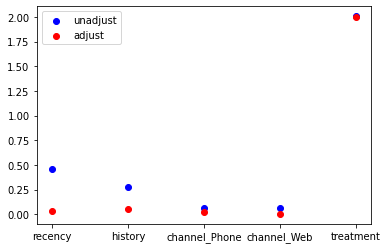

In [66]:
import matplotlib.pyplot as plt

asam_unadjust = (unadjust.query('treatment == 1').mean() - unadjust.query('treatment == 0').mean()) / unadjust.std()
plt.scatter(asam_unadjust.index, asam_unadjust.abs(), color='blue', label='unadjust')

adjust = match.merge(X.reset_index(), on='index', how='left')[['treatment', 'recency', 'history', 'channel_Phone', 'channel_Web']]
asam_adjust = (adjust.query('treatment == 1').mean() - adjust.query('treatment == 0').mean()) / adjust.std()
plt.scatter(asam_adjust.index, asam_adjust.abs(), color='red', label='adjust')

plt.legend()

## 3.2.2 逆確率重み付き推定　IPW

傾向スコアの逆数で重み付けする。

In [67]:
import pandas as pd
from sklearn.linear_model import LogisticRegression


biased_df = pd.read_pickle('data/biased_df.pkl')

y = biased_df['treatment']
X = pd.get_dummies(biased_df[['recency', 'channel', 'history']], columns=['channel'], drop_first=True)

lr = LogisticRegression(random_state=42)
lr.fit(X, y)
ps_score = lr.predict_proba(X)[:, 1]

In [68]:
weight_0 = 1 / (1 - ps_score[y[y == 0].index])
weight_1 = 1 / ps_score[y[y == 1].index]

In [69]:
z_ps = pd.DataFrame({'treatment': y, 'ps_score': ps_score})
z_ps['weight'] = (1 - z_ps['treatment']) / (1 - z_ps['ps_score']) + z_ps['treatment'] / z_ps['ps_score']

In [70]:
z_ps['spend'] = biased_df['spend']
z_ps

,treatment,ps_score,weight,spend
0,0,0.510585,2.043256,0.0
1,0,0.525221,2.106244,0.0
2,0,0.912623,11.444681,0.0
3,0,0.721723,3.593544,0.0
4,0,0.524183,2.101648,0.0
...,...,...,...,...
31920,1,0.316614,3.158424,0.0
31921,1,0.510165,1.960150,0.0
31922,1,0.349279,2.863037,0.0
31923,1,0.361109,2.769248,0.0


In [71]:
z1 = z_ps.query('treatment == 1')
z0 = z_ps.query('treatment == 0')

print((z1['spend'] * z1['weight']).sum() / z1['weight'].sum())
print((z0['spend'] * z0['weight']).sum() / z0['weight'].sum())

1.4758746142116805
0.5902908912501398


In [72]:
1.4758746142116805 - 0.5902908912501398

0.8855837229615408

In [73]:
import statsmodels.api as sm

y = biased_df['spend']
x = sm.add_constant(z_ps['treatment'])
results = sm.WLS(y, x, weights=z_ps['weight']).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     27.07
Date:                Wed, 05 Aug 2020   Prob (F-statistic):           1.97e-07
Time:                        13:14:57   Log-Likelihood:            -1.3278e+05
No. Observations:               31925   AIC:                         2.656e+05
Df Residuals:                   31923   BIC:                         2.656e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5903      0.120      4.920      0.000       0.355       0.825
treatment      0.8856      0.170      5.203      0.000       0.552       1.219
==============================================================================
Omnibus:                    71708.008   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        414882195.972
Skew:                          21.418   Prob(JB):                         0.00
Kurtosis:                     559.828   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 共変量のバランス

In [82]:
z_ps

,treatment,ps_score,weight,spend
0,0,0.510585,2.043256,0.0
1,0,0.525221,2.106244,0.0
2,0,0.912623,11.444681,0.0
3,0,0.721723,3.593544,0.0
4,0,0.524183,2.101648,0.0
...,...,...,...,...
31920,1,0.316614,3.158424,0.0
31921,1,0.510165,1.960150,0.0
31922,1,0.349279,2.863037,0.0
31923,1,0.361109,2.769248,0.0


In [87]:
data = pd.DataFrame()
for column in X.columns:
    data[column] = X[column] * z_ps['weight']
data['treatment'] = biased_df['treatment']
data.head()

,recency,history,channel_Phone,channel_Web,treatment
0,16.346046,1170.070410,0.000000,2.043256,0
1,10.531220,89.262618,2.106244,0.000000,0
2,11.444681,34373.870657,11.444681,0.000000,0
3,3.593544,2379.285260,0.000000,3.593544,0
4,10.508238,93.250103,0.000000,2.101648,0


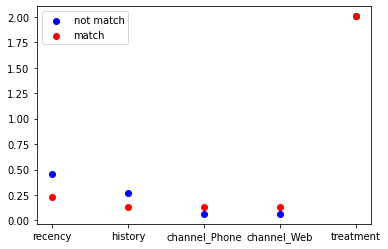

In [89]:
import matplotlib.pyplot as plt

df = pd.concat([X, biased_df['treatment']], axis=1)
match = (df.query('treatment == 1').mean() - df.query('treatment == 0').mean()) / df.std()
plt.scatter(match.index, match.abs(), color='blue', label='not match')

n_match = (data.query('treatment == 1').mean() - data.query('treatment == 0').mean()) / data.std()
plt.scatter(n_match.index, n_match.abs(), color='red', label='match')

plt.legend()